In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/dataset_VQA"

Annotations.zip		train_1000.zip	 vgg16_featues.mat
label_encoder_lstm.pkl	train_small.zip  vgg16_featues_train_1000.mat
test_small.zip		train_sub.zip	 vgg16_featues_val_small.mat
test_sub.zip		val_small.zip	 vgg16_featues_val_sub.mat
test.zip		val_sub.zip	 vgg_feats.mat


In [ ]:
!unzip "/content/drive/MyDrive/dataset_VQA/Annotations.zip"
!unzip "/content/drive/MyDrive/dataset_VQA/train_1000.zip"
!unzip "/content/drive/MyDrive/dataset_VQA/train_small.zip"
!unzip "/content/drive/MyDrive/dataset_VQA/val_small.zip"
!ls Annotations

Archive:  /content/drive/MyDrive/dataset_VQA/Annotations.zip
replace Annotations/val.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/dataset_VQA/train_1000.zip
replace train_1000/VizWiz_train_00000000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/dataset_VQA/train_small.zip
replace train_small/VizWiz_train_00000007.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/dataset_VQA/val_small.zip
replace val_small/VizWiz_val_00000002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
test.json  train.json  val.json


In [ ]:
import json
import spacy
import progressbar
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import operator

from os import listdir
from PIL import Image as PImage
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model
from pickle import dump
import numpy as np
from pathlib import Path

In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
#Load images and split the name to get image id
path = "./train_1000/"
loadedImages_ls = []
imaged_id_num = []
imagesList = listdir(path)
for image in imagesList:
  imagePath = path + '/'+ image
  loadedImages_ls.append(load_img(imagePath, target_size=(224, 224)))
  imaged_id_num.append(str(Path(image).with_suffix('')).split("_")[2])


imgs =loadedImages_ls
print(len(imaged_id_num))
print(imaged_id_num)

1000
['00000855', '00000393', '00000379', '00000390', '00000444', '00000224', '00000499', '00000254', '00000611', '00000185', '00000446', '00000212', '00000404', '00000776', '00000498', '00000825', '00000502', '00000816', '00000014', '00000624', '00000561', '00000209', '00000591', '00000845', '00000703', '00000541', '00000129', '00000094', '00000850', '00000700', '00000255', '00000236', '00000745', '00000231', '00000306', '00000977', '00000311', '00000391', '00000708', '00000076', '00000928', '00000899', '00000728', '00000343', '00000371', '00000497', '00000871', '00000769', '00000252', '00000496', '00000659', '00000376', '00000359', '00000456', '00000707', '00000546', '00000873', '00000666', '00000697', '00000137', '00000357', '00000268', '00000009', '00000451', '00000197', '00000148', '00000249', '00000484', '00000530', '00000215', '00000218', '00000470', '00000299', '00000649', '00000585', '00000314', '00000682', '00000841', '00000995', '00000754', '00000503', '00000513', '00000549'

In [ ]:
#reshape the images to the size of vgg16 model (224,224,3)
images=[]
for i in imgs:
  x = img_to_array(i)
  x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))
  images.append(x)
  x = preprocess_input(x)
  
images = np.vstack(images)
print(images.shape)

(1000, 224, 224, 3)


In [ ]:
#load VGG16 model
model = VGG16()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#remove output layer and get the extracted features
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
features = model.predict(images)
print(features.shape)

(1000, 4096)


In [ ]:
import numpy, scipy.io
scipy.io.savemat('vgg16_featues_train_1000.mat', mdict = {'features': features})

In [ ]:
import spacy
nlp = spacy.load('en_core_web_md')

In [ ]:
#load annotations
anno_val = json.load(open('Annotations/val.json', 'r'))
anno_train = json.load(open('Annotations/train.json', 'r'))
anno_test = json.load(open('Annotations/test.json', 'r'))

In [ ]:
questions_train=[];
image_id_train=[];
answers_train=[];
for i in range(len(anno_train)):
  questions_train.append(anno_train[i]['question'])
  image_id_train.append(anno_train[i]['image'])
  answers_train.append(anno_train[i]['answers'])

print(answers_train[0])

[{'answer_confidence': 'yes', 'answer': 'basil leaves'}, {'answer_confidence': 'yes', 'answer': 'basil leaves'}, {'answer_confidence': 'yes', 'answer': 'basil'}, {'answer_confidence': 'yes', 'answer': 'basil'}, {'answer_confidence': 'yes', 'answer': 'basil leaves'}, {'answer_confidence': 'yes', 'answer': 'basil leaves'}, {'answer_confidence': 'yes', 'answer': 'basil leaves'}, {'answer_confidence': 'yes', 'answer': 'basil leaves'}, {'answer_confidence': 'yes', 'answer': 'basil leaves'}, {'answer_confidence': 'yes', 'answer': 'basil'}]


In [ ]:
#create train file 
import os  
directory = "train"
parent_dir = "/content" 
path = os.path.join(parent_dir, directory)   
try:
    os.makedirs(path, exist_ok = True)
    print("Directory '%s' created successfully" % directory)
except OSError as error:
  print("Directory '%s' is already existed" % directory)  

Directory 'train' created successfully


In [ ]:
progress = progressbar.ProgressBar()

In [ ]:
#get the most frequest answer for each question 
def most_freq_answer(values):
    ans_dict = {}
    for index in range(10):
        ans_dict[values[index]['answer']] = 1
    for index in range(10):
        ans_dict[values[index]['answer']] += 1
    return max(ans_dict.items(), key = operator.itemgetter(1))[0]

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import spacy
from spacy.lang.en.examples import sentences 

import scipy.io
import gc
from sklearn.preprocessing import LabelEncoder
import pickle

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras import Input
from keras.layers.recurrent import LSTM
from keras.layers import concatenate
from keras.layers.merge import Concatenate
from keras.models import model_from_json, Model
from keras.utils.vis_utils import plot_model
from collections import defaultdict
import operator
from keras.utils import np_utils, generic_utils
from progressbar import Bar, ETA, Percentage, ProgressBar
from itertools import zip_longest
from keras.models import load_model

In [ ]:
# image_id_train_file = open('train/image_id_train_file.txt','wb')
# questions_train_file = open('train/questions_train_file.txt', 'wb')
# question_len_train_file = open('train/question_len_train_file.txt', 'wb')
# answers_train_file = open('train/answers_train_file.txt','wb')

In [ ]:
# for index, q  in progress(zip(range(len(questions_train)),questions_train )):
#     questions_train_file.write((q + '\n').encode('utf8'))
#     question_len_train_file.write((str(len(nlp(q))) + '\n').encode('utf8'))
#     image_id_train_file.write((image_id_train[index]+'\n').encode('utf8'))
#     answers_train_file.write(most_freq_answer(answers_train[index]).encode('utf8'))
#     answers_train_file.write('\n'.encode('utf8'))

In [ ]:
questions_train_read =[]
questions_len_read=[]
answers_read=[]
image_id_read=[]
for index, q  in progress(zip(range(len(questions_train)),questions_train )):
  questions_train_read.append(q)
  questions_len_read.append(str(len(nlp(q))))
  answers_read.append(most_freq_answer(answers_train[index]))
  image_id_read.append(image_id_train[index])

| |                                     #         | 20522 Elapsed Time: 0:03:51


In [ ]:
# questions_train_read = open('train/questions_train_file.txt', 'rb').read().decode('utf-8').splitlines()
# questions_len_read = open('train/question_len_train_file.txt', 'rb').read().decode('utf-8').splitlines()
# answers_read = open('train/answers_train_file.txt','rb').read().decode('utf-8').splitlines()
# image_id_read = open('train/image_id_train_file.txt','rb').read().decode('utf-8').splitlines()

In [ ]:
vgg_path = "vgg16_featues_train_1000.mat"

In [ ]:
vgg = scipy.io.loadmat(vgg_path)
features = vgg['features']

In [ ]:
def freq_answers(questions, answers, image_id, upper_lim):
    freq_ans = defaultdict(int)
    for ans in answers:
        freq_ans[ans] +=1
    
    sort = sorted(freq_ans.items(), key=operator.itemgetter(1), reverse=True)[0:upper_lim]
    #print(sort)
    top_ans, top_freq = zip(*sort)
    #print(top_ans, top_freq)
    new_answers_train = list()
    new_questions_train = list()
    new_images_train = list()
    for ans, ques, img in zip(answers, questions, image_id):
        if ans in top_ans:
            new_answers_train.append(ans)
            new_questions_train.append(ques)
            new_images_train.append(img)
    return (new_questions_train, new_answers_train, new_images_train)

In [ ]:
upper_lim = 1000 
questions, answers, image_id = freq_answers(questions_train_read, answers_read, image_id_read, upper_lim)
questions_len, questions, answers_fromUpperlimit, image_id = (list(t) for t in zip(*sorted(zip(questions_len_read, questions, answers, image_id))))
print (len(questions), len(answers_fromUpperlimit),len(image_id))

15556 15556 15556


In [ ]:
batch_size               =     1000 #512
img_dim                  =     4096
word2vec_dim             =      300
num_hidden_nodes_mlp     =     1024
num_hidden_nodes_lstm    =      512
num_layers_lstm          =        3
dropout                  =       0.5
activation_mlp           =     'tanh'
num_epochs               =        5

In [ ]:
image_model = Sequential()
image_model.add(Reshape(input_shape = (4096,), target_shape=(4096,)))
model1 = Model(inputs = image_model.input, outputs = image_model.output)
model1.summary()
print(image_model.input.shape)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2_input (InputLayer  [(None, 4096)]           0         
 )                                                               
                                                                 
 reshape_2 (Reshape)         (None, 4096)              0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
(None, 4096)


In [ ]:
language_model = Sequential()
language_model.add(LSTM(num_hidden_nodes_lstm, return_sequences=True, input_shape=(None, word2vec_dim)))

for i in range(num_layers_lstm-2):
    language_model.add(LSTM(num_hidden_nodes_lstm, return_sequences=True))
    
language_model.add(LSTM(num_hidden_nodes_lstm, return_sequences=False))

model2 = Model(language_model.input, language_model.output)
model2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6_input (InputLayer)   [(None, None, 300)]       0         
                                                                 
 lstm_6 (LSTM)               (None, None, 512)         1665024   
                                                                 
 lstm_7 (LSTM)               (None, None, 512)         2099200   
                                                                 
 lstm_8 (LSTM)               (None, 512)               2099200   
                                                                 
Total params: 5,863,424
Trainable params: 5,863,424
Non-trainable params: 0
_________________________________________________________________


In [ ]:
combined = concatenate([image_model.output, language_model.output])

In [ ]:
model = Dense(num_hidden_nodes_mlp, kernel_initializer='uniform', activation = 'tanh')(combined)
#model = Activation('tanh')(model)
model = Dropout(0.5)(model)

model = Dense(num_hidden_nodes_mlp, kernel_initializer='uniform', activation = 'tanh')(model)
#model = Activation('tanh')(model)
model = Dropout(0.5)(model)

model = Dense(num_hidden_nodes_mlp, kernel_initializer='uniform', activation = 'tanh')(model)
#model = Activation('tanh')(model)
model = Dropout(0.5)(model)

model = Dense(upper_lim)(model)
model = Activation("softmax")(model)

model = Model(inputs=[image_model.input, language_model.input], outputs=model)

In [ ]:
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics = ["accuracy"])
# model.summary()
import tensorflow as tf

optimizer = tf.keras.optimizers.Adam(lr=0.1)
model.compile(loss='categorical_crossentropy', optimizer=optimizer ,metrics = ["accuracy"])
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lstm_6_input (InputLayer)      [(None, None, 300)]  0           []                               
                                                                                                  
 lstm_6 (LSTM)                  (None, None, 512)    1665024     ['lstm_6_input[0][0]']           
                                                                                                  
 reshape_2_input (InputLayer)   [(None, 4096)]       0           []                               
                                                                                                  
 lstm_7 (LSTM)                  (None, None, 512)    2099200     ['lstm_6[0][0]']                 
                                                                                           

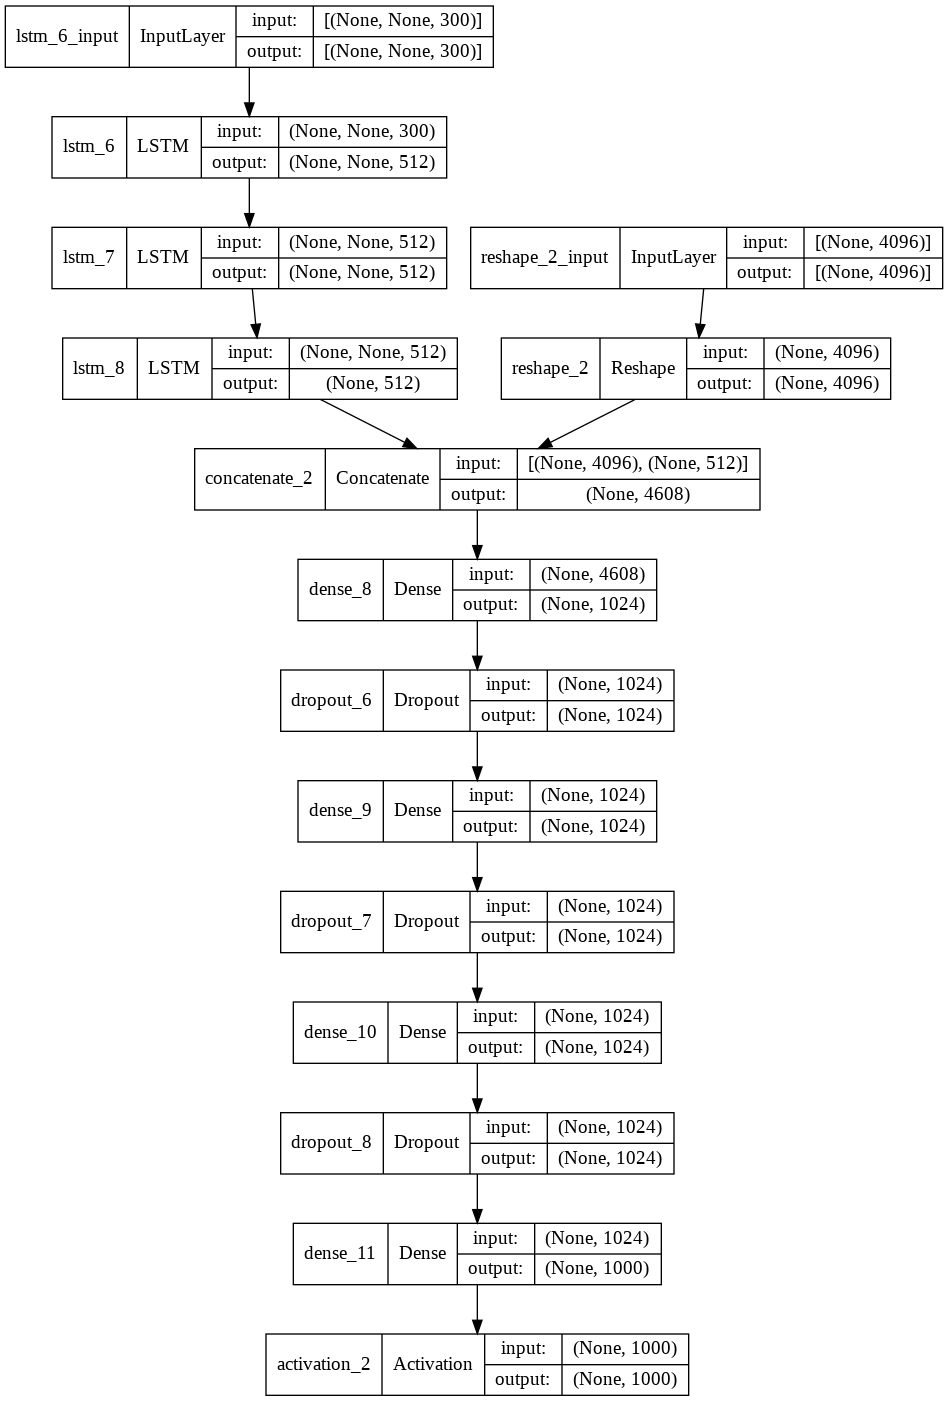

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
le = LabelEncoder()
le.fit(answers)
pickle.dump(le, open('/content/drive/MyDrive/dataset_VQA/label_encoder_lstm.pkl','wb'))

In [ ]:
def get_questions_tensor_timeseries(questions, nlp, timesteps):
    # assert not isinstance(questions, list)
    nb_samples = len(questions)
    word_vec_dim = nlp(questions[0])[0].vector.shape[0]
    questions_tensor = np.zeros((nb_samples, timesteps, word_vec_dim))
    for i in range(len(questions)):
        tokens = nlp(questions[i])
        for j in range(len(tokens)):
            if j<timesteps:
                questions_tensor[i,j,:] = tokens[j].vector
    return questions_tensor

#VGGfeatures --> 1000*4069
def get_images_matrix(img_coco_ids, img_map, VGGfeatures):
    # assert not isinstance(img_coco_ids, list)
    nb_samples = len(img_coco_ids) 
    # print(nb_samples) #20410
    nb_dimensions = VGGfeatures.shape[1]#4069
    image_matrix = np.zeros((nb_dimensions, nb_samples)) #4069*1000 
    
    for j in range(len(img_coco_ids)):
        if img_coco_ids[j] in img_map:
          image_matrix[j,:] = VGGfeatures[:,list(img_map.keys()).index(int(img_coco_ids[j]))]
        image_matrix_trans = image_matrix.transpose()

    return image_matrix_trans

#labelencoder --> we need to convert categorical data into integral data
#3ayzeen 100 egaba yet7welo le 100 integer
def get_answers_sum(answers, encoder):
    # assert not isinstance(answers, list)
    y= encoder.fit_transform(answers)
    # nb_classes = encoder.classes_.shape[0]
    # Y = np_utils.to_categorical(y, nb_classes) 
    Y = np_utils.to_categorical(y, upper_lim)
    return Y

def grouped(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

In [ ]:
id_map = dict()
for id,image_id in zip(range(len(imaged_id_num)),imaged_id_num) :
  id_map[int(image_id)] = id

print(id_map)

{855: 0, 393: 1, 379: 2, 390: 3, 444: 4, 224: 5, 499: 6, 254: 7, 611: 8, 185: 9, 446: 10, 212: 11, 404: 12, 776: 13, 498: 14, 825: 15, 502: 16, 816: 17, 14: 18, 624: 19, 561: 20, 209: 21, 591: 22, 845: 23, 703: 24, 541: 25, 129: 26, 94: 27, 850: 28, 700: 29, 255: 30, 236: 31, 745: 32, 231: 33, 306: 34, 977: 35, 311: 36, 391: 37, 708: 38, 76: 39, 928: 40, 899: 41, 728: 42, 343: 43, 371: 44, 497: 45, 871: 46, 769: 47, 252: 48, 496: 49, 659: 50, 376: 51, 359: 52, 456: 53, 707: 54, 546: 55, 873: 56, 666: 57, 697: 58, 137: 59, 357: 60, 268: 61, 9: 62, 451: 63, 197: 64, 148: 65, 249: 66, 484: 67, 530: 68, 215: 69, 218: 70, 470: 71, 299: 72, 649: 73, 585: 74, 314: 75, 682: 76, 841: 77, 995: 78, 754: 79, 503: 80, 513: 81, 549: 82, 229: 83, 180: 84, 417: 85, 437: 86, 517: 87, 423: 88, 783: 89, 198: 90, 302: 91, 552: 92, 466: 93, 97: 94, 473: 95, 967: 96, 75: 97, 42: 98, 687: 99, 909: 100, 285: 101, 941: 102, 584: 103, 957: 104, 266: 105, 151: 106, 182: 107, 785: 108, 902: 109, 354: 110, 837: 11

In [ ]:
train_questions = questions_train
train_answers = answers_fromUpperlimit
train_image_id = image_id_read

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

timestep = len(nlp(train_questions[-1]))
X_ques_batch = get_questions_tensor_timeseries(train_questions, nlp, timestep)    #equivelant vector for each qutsion.
X_img_batch = get_images_matrix(imaged_id_num, id_map, features)    #pretrained features result of vgg16 layer.
Y_batch = get_answers_sum(train_answers, le)        #equivalent vector for most frquent answers.
print(len(X_img_batch))
print(len(X_ques_batch))
print(len(Y_batch))
model.fit([X_img_batch,X_ques_batch], Y_batch, validation_split=0.33, epochs=20, batch_size=100,verbose=1)

1000
20523
15556
Epoch 1/20
7/7 [==============================] - 15s 2s/step - loss: 157.6258 - accuracy: 0.0613 - val_loss: 91.5732 - val_accuracy: 0.2085
Epoch 2/20
7/7 [==============================] - 15s 2s/step - loss: 85.3761 - accuracy: 0.0747 - val_loss: 79.0570 - val_accuracy: 0.2387
Epoch 3/20
7/7 [==============================] - 15s 2s/step - loss: 74.4314 - accuracy: 0.1091 - val_loss: 113.0899 - val_accuracy: 0.2387
Epoch 4/20
7/7 [==============================] - 15s 2s/step - loss: 97.6319 - accuracy: 0.0867 - val_loss: 140.8446 - val_accuracy: 0.2387
Epoch 5/20
7/7 [==============================] - 15s 2s/step - loss: 108.4093 - accuracy: 0.1151 - val_loss: 151.6436 - val_accuracy: 0.2085
Epoch 6/20
7/7 [==============================] - 15s 2s/step - loss: 108.4789 - accuracy: 0.1046 - val_loss: 141.0266 - val_accuracy: 0.2387
Epoch 7/20
7/7 [==============================] - 14s 2s/step - loss: 105.1319 - accuracy: 0.0942 - val_loss: 156.2749 - val_accuracy: 0

# **Test using validation set** 

---



In [ ]:
#Utility Method to loadImages into list from a given path parameter.
path = "./val_small/"
loadedImages_ls = []
imaged_id_num_val = []
imagesList = listdir(path)
for image in imagesList:
  imagePath = path + '/'+ image
  loadedImages_ls.append(load_img(imagePath, target_size=(224, 224)))
  imaged_id_num_val.append(str(Path(image).with_suffix('')).split("_")[2])

print(len(imaged_id_num_val))
print(imaged_id_num_val)
valImgs =loadedImages_ls

100
['00000539', '00001363', '00001278', '00001096', '00000610', '00000280', '00000541', '00000192', '00001507', '00000682', '00000213', '00001456', '00000152', '00001250', '00000567', '00000211', '00000847', '00000504', '00001144', '00000221', '00000007', '00000002', '00001275', '00000349', '00001088', '00000225', '00001468', '00000676', '00000005', '00000102', '00000310', '00000880', '00000063', '00000744', '00000166', '00000907', '00001219', '00000559', '00000242', '00001548', '00000973', '00000214', '00000637', '00001075', '00000314', '00001288', '00000617', '00000989', '00000571', '00001332', '00001156', '00001647', '00000323', '00001311', '00001177', '00000160', '00001710', '00000171', '00001086', '00000697', '00000485', '00001251', '00001477', '00001169', '00001480', '00001592', '00001035', '00000622', '00000135', '00001321', '00001482', '00001453', '00000039', '00001305', '00000165', '00000477', '00000625', '00000930', '00000732', '00001317', '00000711', '00001397', '00001132',

In [ ]:
valImages=[]
for i in valImgs:
  x = img_to_array(i)
  #print(x.shape)
  x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))
  valImages.append(x)
  #print(x.shape)
  x = preprocess_input(x)
  #print(x.shape)
  
valImages = np.vstack(valImages)
print(valImages.shape)

(100, 224, 224, 3)


In [ ]:
questions_val=[];
image_id_val=[];
answers_val=[];
for i in range(len(anno_val)):
  questions_val.append(anno_val[i]['question'])
  image_id_val.append(anno_val[i]['image'])
  answers_val.append(anno_val[i]['answers'])

print(answers_val[0])

[{'answer': 'unanswerable', 'answer_confidence': 'yes'}, {'answer': 'unanswerable', 'answer_confidence': 'yes'}, {'answer': 'unanswerable', 'answer_confidence': 'yes'}, {'answer': 'unanswerable', 'answer_confidence': 'yes'}, {'answer': 'unanswerable', 'answer_confidence': 'maybe'}, {'answer': 'unanswerable', 'answer_confidence': 'yes'}, {'answer': 'unanswerable', 'answer_confidence': 'yes'}, {'answer': 'unanswerable', 'answer_confidence': 'no'}, {'answer': 'cannot repair this computer automatically', 'answer_confidence': 'maybe'}, {'answer': 'blank screen', 'answer_confidence': 'yes'}]


In [ ]:
#create val file 
import os  
directory = "val"
parent_dir = "/content" 
path = os.path.join(parent_dir, directory)   
try:
    os.makedirs(path, exist_ok = True)
    print("Directory '%s' created successfully" % directory)
except OSError as error:
    print("Directory '%s' is already existed" % directory)  

Directory 'val' created successfully


In [ ]:
# # Opening all .txt files to dump the extracted data
# image_id_val_file = open('val/image_id_val_file.txt','wb')
# questions_val_file = open('val/questions_val_file.txt', 'wb')
# question_len_val_file = open('val/question_len_val_file.txt', 'wb')
# answers_val_file = open('val/answers_val_file.txt','wb')

In [ ]:
questions_val_read=[]
questions_len_val_read=[]
answers_val_read=[]
image_id_val_read=[]
vgg_path_val_small = "vgg16_featues_val_small.mat"

for index, q  in progress(zip(range(len(questions_val)),questions_val )):
    questions_val_read.append(q)
    questions_len_val_read.append(str(len(nlp(q))))
    answers_val_read.append(most_freq_answer(answers_val[index]))
    image_id_val_read.append((image_id_val[index]))

| |                                    #          | 24841 Elapsed Time: 0:17:57

In [ ]:
# for index, q  in progress(zip(range(len(questions_val)),questions_val )):
#     questions_val_file.write((q + '\n').encode('utf8'))
#     question_len_val_file.write((str(len(nlp(q))) + '\n').encode('utf8'))
#     image_id_val_file.write((image_id_val[index]+'\n').encode('utf8'))
#     answers_val_file.write(most_freq_answer(answers_val[index]).encode('utf8'))
#     answers_val_file.write('\n'.encode('utf8'))

In [ ]:
# questions_val_read = open('val/questions_val_file.txt', 'rb').read().decode('utf-8').splitlines()
# questions_len_val_read = open('val/question_len_val_file.txt', 'rb').read().decode('utf-8').splitlines()
# answers_val_read = open('val/answers_val_file.txt','rb').read().decode('utf-8').splitlines()
# image_id_val_read = open('val/image_id_val_file.txt','rb').read().decode('utf-8').splitlines()
# vgg_path_val_small = "vgg16_featues_val_small.mat"

In [ ]:
imaged_id_val_num2 = []
for i in image_id_val_read:
  imaged_id_val_num2.append(int(str(Path(i).with_suffix('')).split("_")[2]))
print(len(imaged_id_val_num2))  
print(imaged_id_val_num2)

4319
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

In [ ]:
upper_lim = 1000
questionsVal, answersVal, image_idVal = freq_answers(questions_val_read, answers_val_read, image_id_val_read, upper_lim)
questions_lenVal, questionsVal, answersVal_fromUpperlimit, image_idVal = (list(t) for t in zip(*sorted(zip(questions_len_val_read, questionsVal, answersVal, image_idVal))))
print (len(questionsVal), len(answersVal_fromUpperlimit),len(image_idVal))

3788 3788 3788


In [ ]:
le = LabelEncoder()
le.fit(answersVal)

LabelEncoder()

In [ ]:
id_map1 = dict()
for id,image_id in zip(range(len(imaged_id_num_val)),imaged_id_num_val) :
  id_map1[int(image_id)] = id
  

print(id_map1)

{539: 0, 1363: 1, 1278: 2, 1096: 3, 610: 4, 280: 5, 541: 6, 192: 7, 1507: 8, 682: 9, 213: 10, 1456: 11, 152: 12, 1250: 13, 567: 14, 211: 15, 847: 16, 504: 17, 1144: 18, 221: 19, 7: 20, 2: 21, 1275: 22, 349: 23, 1088: 24, 225: 25, 1468: 26, 676: 27, 5: 28, 102: 29, 310: 30, 880: 31, 63: 32, 744: 33, 166: 34, 907: 35, 1219: 36, 559: 37, 242: 38, 1548: 39, 973: 40, 214: 41, 637: 42, 1075: 43, 314: 44, 1288: 45, 617: 46, 989: 47, 571: 48, 1332: 49, 1156: 50, 1647: 51, 323: 52, 1311: 53, 1177: 54, 160: 55, 1710: 56, 171: 57, 1086: 58, 697: 59, 485: 60, 1251: 61, 1477: 62, 1169: 63, 1480: 64, 1592: 65, 1035: 66, 622: 67, 135: 68, 1321: 69, 1482: 70, 1453: 71, 39: 72, 1305: 73, 165: 74, 477: 75, 625: 76, 930: 77, 732: 78, 1317: 79, 711: 80, 1397: 81, 1132: 82, 1604: 83, 1394: 84, 864: 85, 731: 86, 785: 87, 770: 88, 817: 89, 465: 90, 223: 91, 956: 92, 1409: 93, 1218: 94, 263: 95, 1411: 96, 1253: 97, 814: 98, 934: 99}


In [ ]:
vgg1 = scipy.io.loadmat(vgg_path_val_small)
features1 = vgg1['features']

In [ ]:
y_pred = []
batch_size = 100 
progbar = generic_utils.Progbar(len(questionsVal))
for qu_batch,an_batch,im_batch in zip(grouped(questionsVal, batch_size,fillvalue=questionsVal[0]), 
                                  grouped(answersVal_fromUpperlimit, batch_size,fillvalue=answersVal_fromUpperlimit[0]), 
                                  grouped(imaged_id_val_num2, batch_size,fillvalue=imaged_id_val_num2[0])):
    timesteps = len(nlp(qu_batch[-1]))
    X_ques_batch = get_questions_tensor_timeseries(qu_batch, nlp, timesteps)
    X_i_batch = get_images_matrix(im_batch, id_map, features1)
    #X_batch = [X_ques_batch, X_i_batch]
    y_predict = model.predict(({'lstm_6_input' : X_ques_batch, 'reshape_2_input' : X_i_batch}))
    y_predict = np.argmax(y_predict,axis=1)
    y_pred.extend(le.inverse_transform(y_predict))
    progbar.add(batch_size)

3800/3788 [==============================] - 135s 36ms/step


In [ ]:
correct_val = 0.0
total = 0

for pred, truth in zip(y_pred, answersVal_fromUpperlimit ):
    t_count = 0
    for _truth in truth.split(';'):
        if pred == truth:
            t_count += 1 
    if t_count >=1:
        correct_val +=1
    else:
        correct_val += float(t_count)/3

    total +=1

In [ ]:
print ("Accuracy: ", round((correct_val/total)*100,2),"%")

Accuracy:  3.17 %
